In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.chebyshev import chebval

## Theory of Chebyshev Polynomials

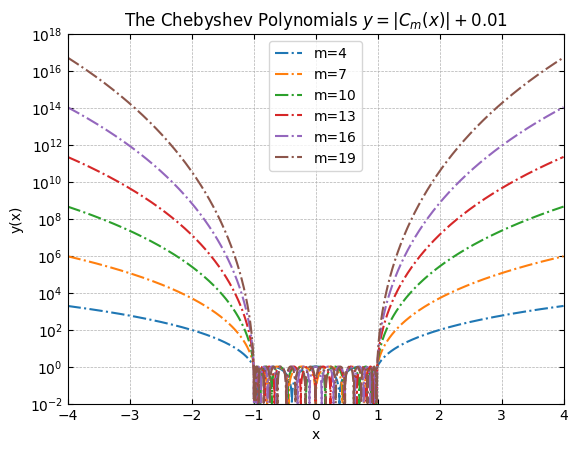

In [81]:
#Create an array from -2 to 2 with 1000 points
x = np.linspace(-4, 4, 100000)

#Write a code for finding m the first kind chebyshev polynomial
m = 20
T = np.zeros((m, x.size))
T[0] = np.ones(x.size)
T[1] = x
C=np.zeros((m, x.size))
for i in range(2, m):
    T[i] = 2*x*T[i-1] - T[i-2] + 0.01

for i in range (m):
    C[i] = np.abs(T[i])+0.01

#Plot the first kind chebyshev polynomial
plt.figure()
for i in range(4,m,3):
    plt.plot(x, C[i], label="m={}".format(i), linestyle="-.")
plt.legend()
plt.xlabel("x")
plt.ylabel("y(x)")
# y range from 10^-2 to 10^18
plt.ylim(1e-2, 1e18)
plt.xlim(-4, 4)
#y in semi log
plt.yscale("log")
# show ticks on both sides
plt.tick_params(axis='both', direction='in')
# Show ticks on right as well as top
plt.tick_params(top=True, right=True)
# Add labels on y axis after 10^2
plt.yticks([1e-2, 1e0, 1e2, 1e4, 1e6, 1e8, 1e10, 1e12, 1e14, 1e16, 1e18], ["$10^{-2}$", "$10^{0}$", "$10^{2}$", "$10^{4}$", "$10^{6}$", "$10^{8}$", "$10^{10}$", "$10^{12}$", "$10^{14}$", "$10^{16}$", "$10^{18}$"])

plt.title("The Chebyshev Polynomials $y = |C_m(x)|+0.01$")
plt.grid( linestyle='--', linewidth=0.5)
plt.show()


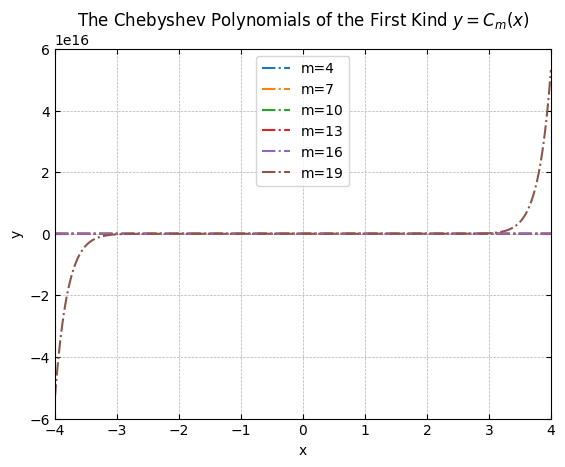

In [82]:
plt.figure()
for i in range(4,m,3):
    plt.plot(x, T[i], label="m={}".format(i), linestyle="-.")
plt.legend( loc='upper center')
plt.xlabel("x")
plt.ylabel("y")
plt.tick_params(axis='both', direction='in')
plt.tick_params(top=True, right=True)
plt.title("The Chebyshev Polynomials of the First Kind $y=C_m(x)$")
plt.xlim(-4,4)
plt.ylim(-6e16,6e16)
plt.grid( linestyle='--', linewidth=0.5)
plt.show()

## The condition number problem!!

In [102]:
def condition_number(n, N):
    
    # Create a random symmetric matrix of size n x n
    H = np.random.randn(n, n) + 1j*np.random.randn(n, n)
    H = 0.5 * (H + H.conj().T)  # Ensuring symmetry
    cond_H = np.linalg.cond(H)

    # Create a random matrix of size n x N
    A = np.random.randn(n, N) + 1j*np.random.randn(n, N)
    cond_A = np.linalg.cond(A)

    # Compute the minimum eigenvalue of H
    a_L = np.min(np.abs(np.linalg.eigvalsh(H)))

    # Create a random vector of size n x 1
    b = np.random.randn(n, 1) + 1j*np.random.randn(n, 1)

    # Compute Chebyshev polynomials iteratively
    B = np.empty((n, N), dtype=np.complex128)
    B[:, 0] = (b).flatten()

    if N > 1:
        B[:, 1] = (H/a_L @ b).flatten()

    T_k_prev = 1
    T_k_curr = a_L
    T_prev = np.eye(n)  # T_0 = I
    T_curr = H          # T_1 = H

    for i in range(2, N):
        T_next = 2 * H @ T_curr - T_prev
        T_k_next = 2 * a_L * T_k_curr - T_k_prev
        B[:, i] = ((T_next / T_k_next) @ b).flatten()
        T_prev, T_curr = T_curr, T_next  # Move forward in recurrence
        T_k_prev, T_k_curr = T_k_curr, T_k_next

    cond_B = np.linalg.cond(B)

    # Compute power-based matrix `C` iteratively
    C = np.empty((n, N),dtype=np.complex128)
    C[:, 0] = b.flatten()
    for i in range(1, N):
        C[:, i] = (H @ C[:, i - 1]).flatten()  # Avoid unnecessary slicing

    cond_C = np.linalg.cond(C)

    return cond_H, cond_A, cond_B, cond_C


In [103]:
n=[10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
N=10
cond_H=[]
cond_A=[]
cond_B=[]
cond_C=[]
for i in n:
    a,b,c,d=condition_number(i,N)
    cond_H.append(a)
    cond_A.append(b)
    cond_B.append(c)
    cond_C.append(d)
    

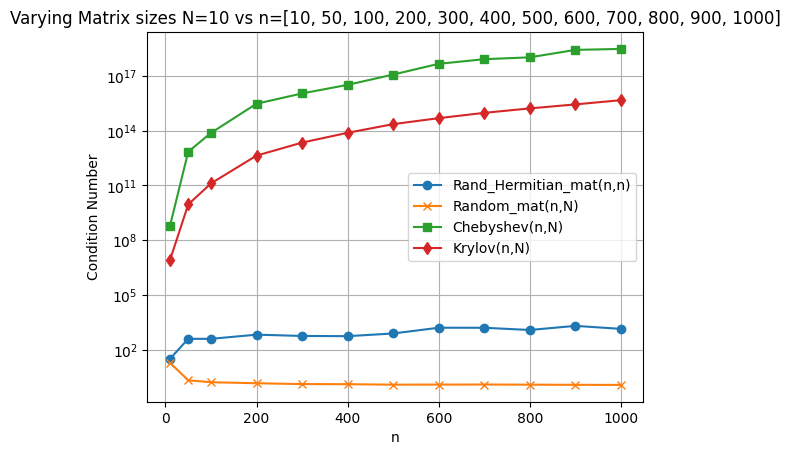

In [104]:
# Plot
plt.figure()
plt.plot(n, cond_H, label="Rand_Hermitian_mat(n,n)", marker="o")
plt.plot(n, cond_A, label="Random_mat(n,N)", marker="x")
plt.plot(n, cond_B, label="Chebyshev(n,N)", marker="s")
plt.plot(n, cond_C, label="Krylov(n,N)", marker="d")
plt.legend()
plt.yscale("log")
# plt.xscale("log")
plt.xlabel("n")
plt.ylabel("Condition Number")
plt.title(f"Varying Matrix sizes {N=} vs {n=}", fontsize=12)
plt.grid()
plt.show()

In [85]:
n=100
N=[5, 10, 15, 20 ,25, 30, 35, 50]
cond_H_=[]
cond_A_=[]
cond_B_=[]
cond_C_=[]
for i in N:
    a,b,c,d = condition_number(n,i)
    cond_H_.append(a)
    cond_A_.append(b)
    cond_B_.append(c)
    cond_C_.append(d)

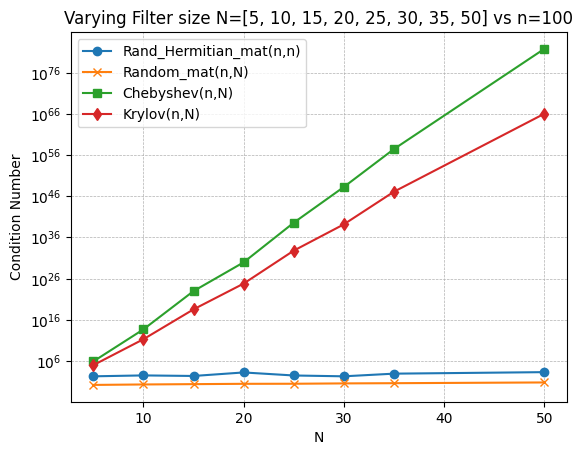

In [86]:
#Plot
plt.figure()
plt.plot(N, cond_H_, label="Rand_Hermitian_mat(n,n)", marker="o")
plt.plot(N, cond_A_, label="Random_mat(n,N)", marker="x")
plt.plot(N, cond_B_, label="Chebyshev(n,N)", marker="s")
plt.plot(N, cond_C_, label="Krylov(n,N)", marker="d")
plt.legend()
plt.yscale("log")
plt.xlabel("N")
plt.ylabel("Condition Number")
plt.title(f"Varying Filter size {N=} vs {n=}", fontsize=12)
plt.grid( linestyle='--', linewidth=0.5)
plt.show()

## Comparison of Cholesky Factorization, Diagonalization and Hybrid Methods for Solving EVP

In [2]:
def lookup(b):
    if b <=500:
        return 24
    elif b<=750:
        return 30
    elif b<=1000:
        return 39
    elif b<=1500:
        return 50
    elif b<=2000:
        return 53
    elif b<=3000:
        return 57
    elif b<=4000:
        return 62
    elif b<=5000:
        return 69
    elif b<=9000:
        return 77
    elif b<=14000:
        return 104
    elif b<=20000:
        return 119
    elif b<=30000:
        return 162
    elif b<=50000:
        return 300
    elif b<=80000:
        return 450
    elif b<=100000:
        return 550
    elif b<=200000:
        return 700
    elif b<=500000:
        return 1000

In [81]:
# Generate a Real Symmetric Matrix
def generate_hermitian_matrix(M):
    """Generates an M x M random Hermitian matrix."""
    # H = np.random.randn(M, M) + 1j * np.random.randn(M, M)
    # H = 0.5 * (H + H.conj().T)  # Ensure Hermitian


    # Generate a synthetic matrix H_ij = exp(-0.5 *|i-j|) * sin(i+1)
    i, j = np.meshgrid(np.arange(M), np.arange(M), indexing="ij")
    H = np.exp(-0.5 * np.abs(i - j)) * np.sin(i + j)
    # H[np.abs(H) < 1e-5] = 0  # Set small values to zero
    return H

def Chebyshev_poly(H, a, b, k):
    """Computes the k-th order Chebyshev polynomial T_k(H)."""
    M = H.shape[0]
    H = (H - ((a + b) / 2) * np.eye(M)) / ((b - a) / 2)  # Normalize eigenvalues

    T_curr = np.eye(M)  
    T_next = H.copy()  # Avoid aliasing

    for _ in range(2, k + 1):
        T_new = 2 * H @ T_next - T_curr
        T_curr, T_next = T_next, T_new  # Efficient swapping

    return T_next

def Chebyshev_scalar_poly(x, a, b, k):
    """Computes the k-th order Chebyshev polynomial T_k(x)."""
    coeffs = np.zeros(k + 1)
    coeffs[k] = 1  # Set T_k coefficient to 1
    return chebval((x-((a+b)/2))/((b-a)/2), coeffs)

## Method 1: Cholesky Factorization

In [70]:
def ChFSI_cholalgo(H, Psi, T_kH):
        
        # Chebyshev Filtering
        Psi_F = T_kH @ Psi

        # Overlap Matrix
        S = Psi_F.conj().T @ Psi_F

        # Regularization to ensure positive definiteness
        # S += np.eye(S.shape[0]) * 1e-10
 
        #Cholesky decomposition
        L = np.linalg.cholesky(S)
        
        # orthogonalization
        Psi = Psi_F @ (np.linalg.inv(L).conj().T)
        
        eigenvals = np.einsum('ji,jk,ki->i', Psi.conj(), H, Psi)
        eigenvecs = Psi

        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        eigenvecs = eigenvecs[:,idx]

        return eigenvals, eigenvecs


def ChFSI_chol(Psi, H, k = 24, Ntilde = 10, buffer = 20, epsilon = 1e-16, max_iter = 100):
    # H is a Hermitian Matrix
    # N is the number of eigenvalues to be found
    # k is the degree of the Chebyshev polynomial filter

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    #Initializing matrices and variables
    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)
    eigenvecs = np.empty((M,N),dtype=complex)

    eigenvalsh = np.linalg.eigvalsh(H)
    a_0, b = np.min(eigenvalsh), np.max(eigenvalsh)

    a_L = a_0
    k = lookup(b)
    a = (((b - a_0)/M)*N) + a_0
    T_kH = Chebyshev_poly(H,a,b,k) / Chebyshev_scalar_poly(a_L, a, b, k)

    print()
    print("ChFSI with Cholesky Decomposition Parameters")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Degree of Chebyshev Polynomial: {k}")
    print(f"Upper bound of Spectrum b = ", b)
    print(f"Lower bound of Spectrum a_0 = ", a_0)
    print(F"Initial guess of Lower bound of wanted spectrum a = ", a)
    print(f"a_L = ", a_L)
    print()

    # Algorithm
    while itr < max_iter and residual[itr] >= epsilon:

        eigenvals, eigenvecs = ChFSI_cholalgo(H, Psi, T_kH)
        Psi = eigenvecs

        residual.append(np.max(np.linalg.norm(H @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))

        a = np.max(eigenvals)
        T_kH = Chebyshev_poly(H, a, b, k) / Chebyshev_scalar_poly(a_L, a, b, k)
        itr+=1

    return eigenvals, eigenvecs, itr, residual

## Method 2: Eigenvalue Decomposition

In [71]:
def generalized_eigenproblem(H, S):
    """ Solves the generalized eigenvalue problem H X = S X Lambda """

    # # Regularization to make S positive definite
    # S += np.eye(S.shape[0]) * 1e-10

    # Cholesky decomposition of S (S = L L^T)
    L = np.linalg.cholesky(S)
    
    # Transform H to standard eigenvalue problem
    Linv = np.linalg.inv(L)
    H_tilde = Linv @ H @ Linv.conj().T  # Equivalent to L^{-1} H L^{-dag}

    # Solve standard eigenvalue problem
    eigenvals, Q = np.linalg.eigh(H_tilde)

    # Recover original eigenvectors
    eigenvecs = np.linalg.inv(L.conj().T) @ Q

    return eigenvals, eigenvecs

def ChFSI_diagalgo(H, Psi, T_kH):

        # Chebyshev Filtering
        Psi_F = T_kH @ Psi

        # Projected Matrix
        H_proj = Psi_F.conj().T @ H @ Psi_F

        # Overlap Matrix
        S = Psi_F.conj().T @ Psi_F
        
        # Diagonalization
        eigenvals, eigvecs = generalized_eigenproblem(H_proj, S)
  
        # orthogonalization
        Psi = Psi_F @ eigvecs

        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        eigenvecs = Psi[:,idx]

        return eigenvals, eigenvecs


def ChFSI_diag(Psi, H, k = 24, Ntilde = 10, buffer = 20, epsilon = 1e-16, max_iter = 100):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found

    # Print Rank of Psi Matrix
    # print(f"Rank of Psi Matrix: {np.linalg.matrix_rank(Psi)}")

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)
    eigenvecs = np.empty((M,N),dtype=complex)
    
    eigenvalsh = np.linalg.eigvalsh(H)
    a_0, b = np.min(eigenvalsh), np.max(eigenvalsh)

    a_L = a_0
    k = lookup(b)
    a = (((b - a_0)/M)*N) + a_0
    T_kH = Chebyshev_poly(H, a, b, k) / Chebyshev_scalar_poly(a_L, a, b, k)

    print()
    print("ChFSI with Diagonalization Parameters")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Degree of Chebyshev Polynomial: {k}")
    print(f"Upper bound of Spectrum b = ", b)
    print(f"Lower bound of Spectrum a_0 = ", a_0)
    print(F"Initial guess of Lower bound of wanted spectrum a = ", a)
    print(f"a_L = ", a_L)
    print()

    
    # Algorithm
    while itr < max_iter and residual[itr] >= epsilon:

        eigenvals, eigenvecs = ChFSI_diagalgo(H, Psi, T_kH)

        Psi = eigenvecs

        residual.append(np.max(np.linalg.norm(H @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))

        a = np.max(eigenvals)
        T_kH = Chebyshev_poly(H, a, b, k) / Chebyshev_scalar_poly(a_L, a, b, k)
        itr+=1

    return eigenvals, eigenvecs, itr, residual

## Method 3: Hybrid Method

In [72]:
def ChFSI_hybd(Psi, H, k = 24, Ntilde = 10, buffer = 20, l = 10, epsilon = 1e-16, max_iter = 100):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found
    # k is the degree of the Chebyshev polynomial filter
    # a is the period of algorithm to be used

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    #Initializing matrices and variables
    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)
    eigenvecs = np.empty((M,N),dtype=complex)
    
    eigenvalsh = np.linalg.eigvalsh(H)
    a_0, b = np.min(eigenvalsh), np.max(eigenvalsh)

    a_L = a_0
    k = lookup(b)
    a = (((b - a_0)/M)*N) + a_0
    T_kH = Chebyshev_poly(H, a, b, k) / Chebyshev_scalar_poly(a_L, a, b, k)

    print()
    print("ChFSI with Hybrid Method Parameters")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Degree of Chebyshev Polynomial: {k}")
    print(f"Upper bound of Spectrum b = ", b)
    print(f"Lower bound of Spectrum a_0 = ", a_0)
    print(F"Initial guess of Lower bound of wanted spectrum a = ", a)
    print(f"a_L = ", a_L)
    print("The period of algorithm is ", l)
    print()

    # Algorithm
    while itr < max_iter and residual[itr] >= epsilon:
        
        if (((itr % l) == 0) or ((itr+1)==max_iter)) and (itr!=0):
            eigenvals, eigenvecs = ChFSI_diagalgo(H, Psi, T_kH)
        else:
            eigenvals, eigenvecs = ChFSI_cholalgo(H, Psi,T_kH)
            
        Psi = eigenvecs
        
        residual.append(np.max(np.linalg.norm(H @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))

        a = np.max(eigenvals)
        T_kH = Chebyshev_poly(H, a, b, k) / Chebyshev_scalar_poly(a_L, a, b, k)
        itr+=1

    return eigenvals, eigenvecs, itr, residual

In [78]:
# Parameters
M =  1024 # Dimension of the matrix
Ntilde = 10  # Number of eigenvalues
buffer = 20  # Buffer for the number of eigenvalues
N = int((1+(buffer/100)) * Ntilde)  # Number of eigenvalues to be found
Psi = np.random.randn(M, N) + 1j * np.random.randn(M,N)
k = 24  # Degree of Chebyshev polynomial
epsilon = 1e-12  # Tolerance for convergence
max_iter = 25 # Maximum number of iterations
l = 5 # Period of the algorithm for Hybrid Algorithm
H = generate_hermitian_matrix(M)

print("Matrix Size: ", M)
print("Number of Eigenvalues: ", Ntilde)
print("Buffer: ", buffer)
print("Initial space size: ", N)
print("Degree of Chebyshev Polynomial: ", k)
print("Convergence Threshold: ", epsilon)
print("Max Iterations: ", max_iter)
print("Period of Algorithm: ", l)

Matrix Size:  1024
Number of Eigenvalues:  10
Buffer:  20
Initial space size:  12
Degree of Chebyshev Polynomial:  24
Convergence Threshold:  1e-12
Max Iterations:  25
Period of Algorithm:  5


In [79]:
# Solving the problem
eigenvals_chol, eigenvecs_chol, itr_chol, residual_chol = ChFSI_chol(Psi, H, k, Ntilde, buffer, epsilon, max_iter)
eigenvals_diag, eigenvecs_diag, itr_diag, residual_diag = ChFSI_diag(Psi, H, k, Ntilde, buffer, epsilon, max_iter)
eigenvals_hybd, eigenvecs_hybd, itr_hybd, residual_hybd = ChFSI_hybd(Psi, H, k, Ntilde, buffer, l, epsilon, max_iter)
eigenvals, eigenvecs = np.linalg.eigh(H)


ChFSI with Cholesky Decomposition Parameters
Number of Eigenvalues: 10
Buffer: 20%
Convergence Threshold: 1e-12
Max Iterations: 25
Degree of Chebyshev Polynomial: 24
Upper bound of Spectrum b =  63.525334185154875
Lower bound of Spectrum a_0 =  -63.41256914280895
Initial guess of Lower bound of wanted spectrum a =  -61.92501558818437
a_L =  -63.41256914280895


ChFSI with Diagonalization Parameters
Number of Eigenvalues: 10
Buffer: 20%
Convergence Threshold: 1e-12
Max Iterations: 25
Degree of Chebyshev Polynomial: 24
Upper bound of Spectrum b =  63.525334185154875
Lower bound of Spectrum a_0 =  -63.41256914280895
Initial guess of Lower bound of wanted spectrum a =  -61.92501558818437
a_L =  -63.41256914280895


ChFSI with Hybrid Method Parameters
Number of Eigenvalues: 10
Buffer: 20%
Convergence Threshold: 1e-12
Max Iterations: 25
Degree of Chebyshev Polynomial: 24
Upper bound of Spectrum b =  63.525334185154875
Lower bound of Spectrum a_0 =  -63.41256914280895
Initial guess of Lower 

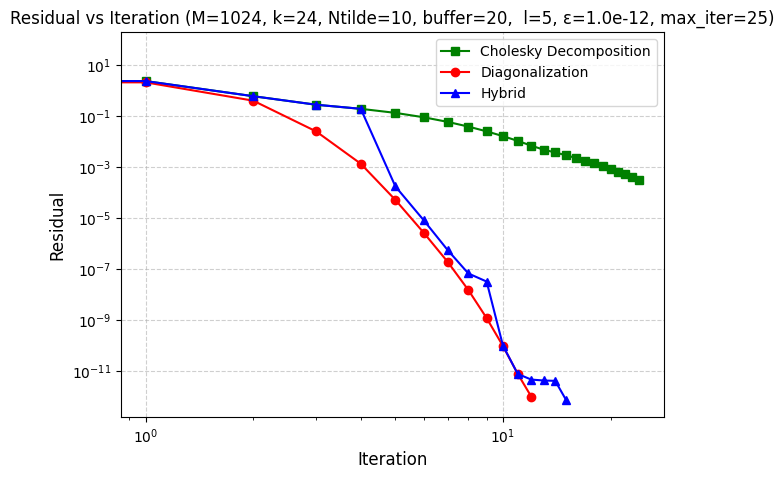

In [80]:
# Plot the error
plt.figure(figsize=(7, 5))
plt.title(f"Residual vs Iteration (M={M}, k={k}, Ntilde={Ntilde}, buffer={buffer},  l={l}, ε={epsilon:.1e}, max_iter={max_iter})")

plt.plot(np.arange(len(residual_chol)-1), residual_chol[1:], marker='s',  label="Cholesky Decomposition",color="green")
plt.plot(np.arange(len(residual_diag)-1), residual_diag[1:], marker='o',  label="Diagonalization", color="red")
plt.plot(np.arange(len(residual_hybd)-1), residual_hybd[1:], marker='^',  label="Hybrid",color="blue")

plt.yscale("log")
plt.xscale("log")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Residual", fontsize=12)
# Legend adjustments
plt.legend()
plt.show()

In [ ]:
print("Eigenvalues (Cholesky):", eigenvals_chol)
print("Eigenvalues (Diagonalization):", eigenvals_diag)
print("Eigenvalues (Hybrid):", eigenvals_hybd)
print("Eigenvalues (Exact):", eigenvals)

Eigenvalues (Cholesky): [-2.04824635-1.11022302e-16j -2.02676916-2.77555756e-17j
 -1.99215613+3.33066907e-16j -1.94685681+0.00000000e+00j
 -1.88145282-2.22044605e-16j]
Eigenvalues (Exact) in sorted order: [[-8.03131501e-01 -1.51701709e-01 -8.80083394e-02 -8.53969788e-02
  -7.57857959e-02 -7.21000886e-02 -7.04675842e-02 -6.75025492e-02
  -6.27167820e-02 -5.61495080e-02 -4.23756882e-02 -3.69956047e-02
  -2.49915691e-02 -1.52722332e-02 -1.20743887e-02 -1.15786814e-02
  -5.65688425e-05 -6.42651415e-07 -2.26186324e-07 -1.56131975e-07
  -8.27465961e-08 -3.50968803e-10 -8.92548267e-11 -8.13673380e-11
  -1.98356526e-11 -3.34786224e-12 -4.68029478e-13 -1.44849410e-15
  -7.83227649e-16 -2.49800181e-16 -1.04950770e-16 -5.89805982e-17
  -5.33427469e-17 -4.64038530e-17  4.35849273e-17  5.81023944e-16
   7.19910243e-16  7.57640478e-16  2.25275527e-15  7.77069381e-15
   1.29523894e-11  5.11021131e-09  6.55965129e-09  7.45904335e-09
   8.14442696e-07  9.97926683e-07  2.99625200e-06  3.65337517e-06
   

In [ ]:
print("Eigenvecs (Diagonalization):", eigenvecs_diag)
print("Eigenvecs (Cholesky):", eigenvecs_chol)
print("Eigenvecs (Hybrid):", eigenvecs_hybd)
print("Eigenvecs (Exact):", eigenvecs)

Eigenvecs (Diagonalization): [[ 2.26569278e-10+2.32636114e-10j -6.38899167e-11-5.69588699e-11j
   1.15876616e-10+5.00187491e-10j ... -1.82098331e-10+1.96442135e-10j
  -3.28135801e-10-4.02365588e-10j  3.11564869e-10+1.62775136e-10j]
 [-6.18399763e-11+2.95788603e-09j -1.49778939e-10-6.82015387e-10j
  -4.79837924e-11+2.00387618e-10j ...  7.14246973e-10+9.05293670e-10j
  -1.56551077e-09-2.05858018e-09j  1.01584286e-09+6.63852786e-10j]
 [-6.98705801e-03+3.55521873e-03j -1.95177951e-03+3.29613963e-03j
  -9.32318466e-03-3.54091480e-03j ... -3.16333479e-03+3.06957271e-03j
   2.64936179e-02+1.72360587e-02j  2.24922526e-03-2.81817854e-02j]
 ...
 [ 5.95832884e-03+7.79501957e-03j  3.22783562e-02+4.97347683e-03j
   3.16119085e-02+1.89510685e-02j ...  3.64907282e-03-1.40848126e-02j
   1.32597059e-03+4.49769460e-02j  2.30859644e-02+2.29145703e-02j]
 [ 1.29758707e-02+2.28601557e-02j  7.21760801e-03+6.02595617e-02j
   1.75903654e-02+2.90106279e-03j ... -5.90664531e-02-4.96210563e-02j
   5.68318384e-03-